In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github')))
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github/Method')))
import numpy as np
import torch
from datetime import datetime
from utils import (root_mean_squared_error, mean_absolute_error, print_stats,plot_forecasts_multi)
from Baseline import three_freq_midas_lagged_regression, midas_forecast_low_only, set_seed

np.printoptions(precision=4, suppress=True)
np.set_printoptions(precision=4, suppress=True)
set_seed(42)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

#data parameters
d1 = 20
d2 = 3
P1 = 13
P2 = 56
P3 = 9
Q = 5

Pre-COVID19

In [2]:
T = 188
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print_stats(Y, 'Y')
print_stats(X_M, 'X_M')
print_stats(X_H, 'X_H')
# Y_total = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
# print('Y_total shape:', Y_total.shape)

T 188 T_H: 11280 T_M: 564
T_train: 148 T_val: 20 T_test: 20
--- Y ---
Shape: (9, 188)
Stat: max=9.0831  min=-4.5942  mean=0.0039  std=0.8721
--- X_M ---
Shape: (56, 564)
Stat: max=16.9403  min=-17.1282  mean=0.0004  std=0.8662
--- X_H ---
Shape: (13, 11280)
Stat: max=23.1950  min=-25.5649  mean=0.0001  std=0.9700


==== Step 0
Y_final_np (167, 5)
X_final_np (167, 78)
params_high tensor([-0.1241,  0.0052], device='cuda:0')
params_med tensor([7.3313e-06, 1.2440e-01], device='cuda:0')
w_high [0.0579 0.0535 0.0499 0.047  0.0448 0.0431 0.0419 0.0412 0.0409 0.0411
 0.0417 0.0427 0.0443 0.0463 0.049  0.0524 0.0566 0.0617 0.0681 0.0759]
w_med [0.5245 0.2816 0.1939]
w_high [0.0579 0.0535 0.0499 0.047  0.0448 0.0431 0.0419 0.0412 0.0409 0.0411
 0.0417 0.0427 0.0443 0.0463 0.049  0.0524 0.0566 0.0617 0.0681 0.0759]
w_med [0.5245 0.2816 0.1939]
X_low_t torch.Size([9, 1])
X_low_freq torch.Size([69, 1])
==== Step 1
Y_final_np (168, 5)
X_final_np (168, 78)
params_high tensor([-0.2195, -0.0028], device='cuda:0')
params_med tensor([-2.4590e-10,  1.9620e-01], device='cuda:0')
w_high [0.0011 0.0015 0.0021 0.0029 0.004  0.0054 0.0073 0.0098 0.0131 0.0175
 0.023  0.0303 0.0395 0.0513 0.0662 0.0851 0.1086 0.138  0.1742 0.2188]
w_med [0.6317 0.2368 0.1315]
w_high [0.0011 0.0015 0.0021 0.0029 0.004  0.0054 0.0073 0.0098

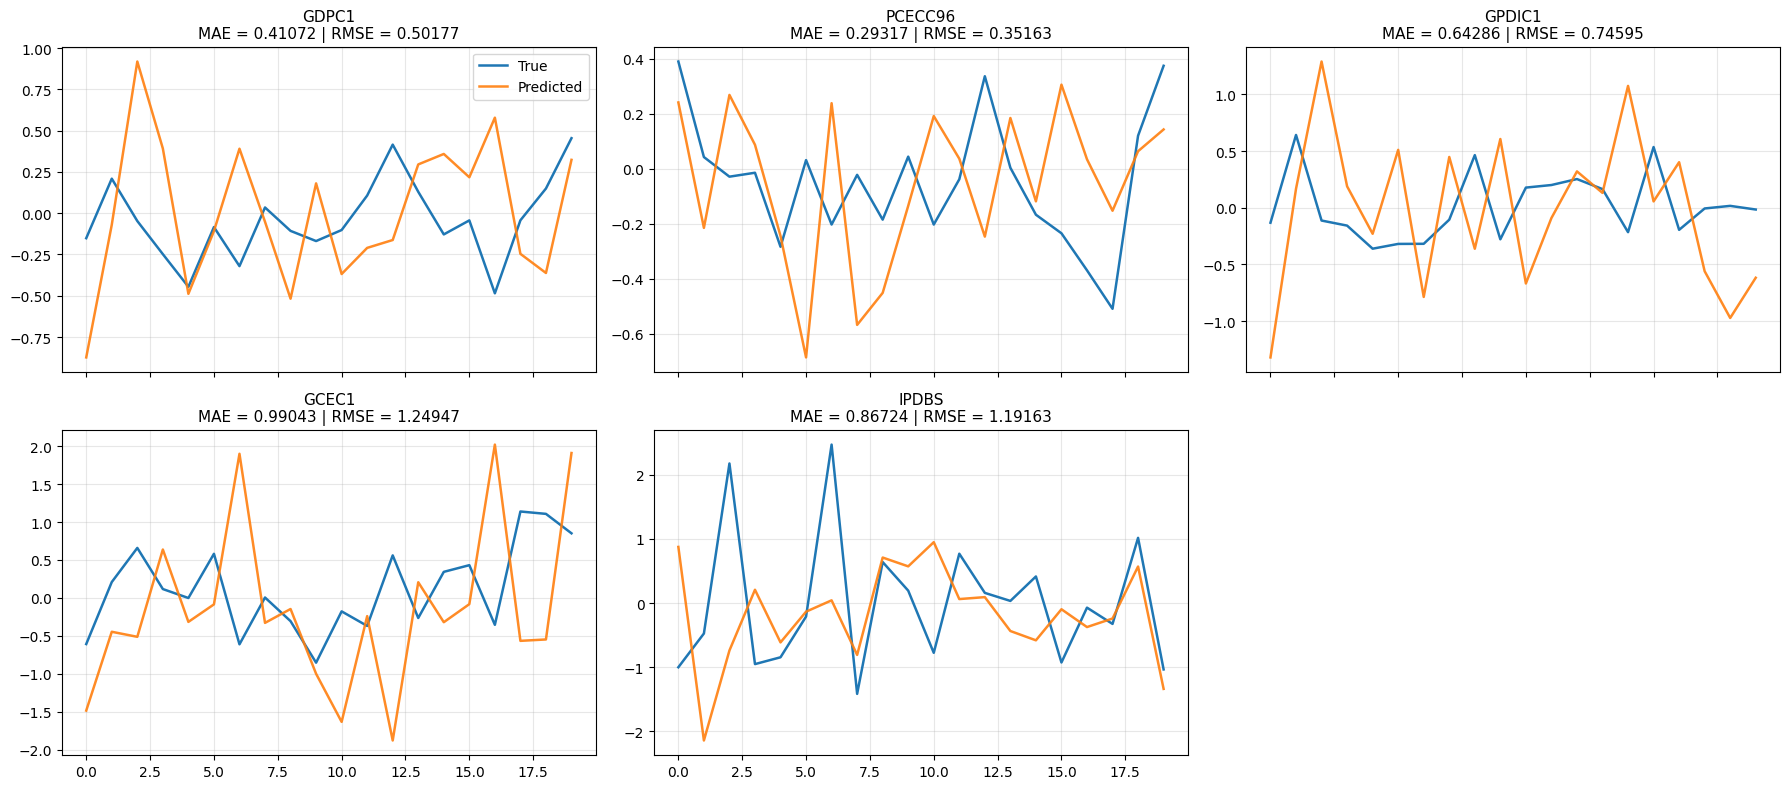


All direct multi-step forecasts and plots saved successfully.


In [4]:
k = 1
Weight_choice = 'Nealmon'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'  # 'Powell' or 'L-BFGS-B'
inits = [0,0,0,0]
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_MIDAS = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1

    for t in range(T_test):
        print(f'==== Step {t}')
        X_H_train = X_H[:, :(T_train+T_val+t-target_horizon+1)*d1*d2] 
        X_M_train = X_M[:, :(T_train+T_val+t-target_horizon+1)*d2] 
        Y_train = Y[:, target_horizon-1:(T_train+T_val+t)] 
        X_H_test = X_H[:, (T_train+T_val+t-k-target_horizon+1)*d1*d2:(T_train+T_val+t-target_horizon+1)*d1*d2]     
        X_M_test = X_M[:, (T_train+T_val+t-k-target_horizon+1)*d2:(T_train+T_val+t-target_horizon+1)*d2]        
        Y_test = Y[:, T_train + T_val - k + t-target_horizon+1: T_train + T_val + t-target_horizon+1]    
                    
        model, w_high, w_med = three_freq_midas_lagged_regression(Y_train, X_M_train, X_H_train, d1, d2, k, Weight_choice, device, Q=5
                                                                  ,method=method,inits=inits)
        print('w_high',w_high)
        print('w_med',w_med)
        forecast_MIDAS = midas_forecast_low_only(
            model, Y_test, X_M_test, X_H_test, k, d1, d2, w_high, w_med, device)
        forecasts_multi[i, :, t] = forecast_MIDAS
        # print('forecast_test_MIDAS', forecast_test_MIDAS)
# Calculate forecast errors
Y_true = Y[:Q, T_train + T_val:] 
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS_{Weight_choice}_k{k}_horizon{h+1}.png',
        title_prefix=f'MIDAS Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")



==== Step 0


/home/yzwang/MF/Method/Baseline.py:4983: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective, inits, method=method, bounds=bounds)


Y_final_np (167, 5)
X_final_np (167, 78)
params_high tensor([1.2698, 3.0000], device='cuda:0')
params_med tensor([2.9999, 2.9999], device='cuda:0')
w_high [0.     0.0007 0.0027 0.0059 0.0104 0.0159 0.0224 0.0298 0.038  0.0469
 0.0562 0.0659 0.0757 0.0852 0.094  0.1017 0.107  0.1084 0.1009 0.0324]
w_med [0.0004 0.9992 0.0004]
X_low_t torch.Size([9, 1])
X_low_freq torch.Size([69, 1])
==== Step 1
Y_final_np (168, 5)
X_final_np (168, 78)
params_high tensor([1.4084, 3.0000], device='cuda:0')
params_med tensor([2.3806, 2.8471], device='cuda:0')
w_high [0.     0.0008 0.0033 0.0072 0.0124 0.0188 0.0262 0.0345 0.0435 0.0529
 0.0626 0.0722 0.0813 0.0896 0.0965 0.1011 0.1023 0.0979 0.0829 0.014 ]
w_med [0.0005 0.9934 0.0061]
X_low_t torch.Size([9, 1])
X_low_freq torch.Size([69, 1])
==== Step 2
Y_final_np (169, 5)
X_final_np (169, 78)
params_high tensor([1.2979, 3.0000], device='cuda:0')
params_med tensor([2.8506, 2.9999], device='cuda:0')
w_high [0.     0.0007 0.0028 0.0062 0.0108 0.0165 0.0232 0

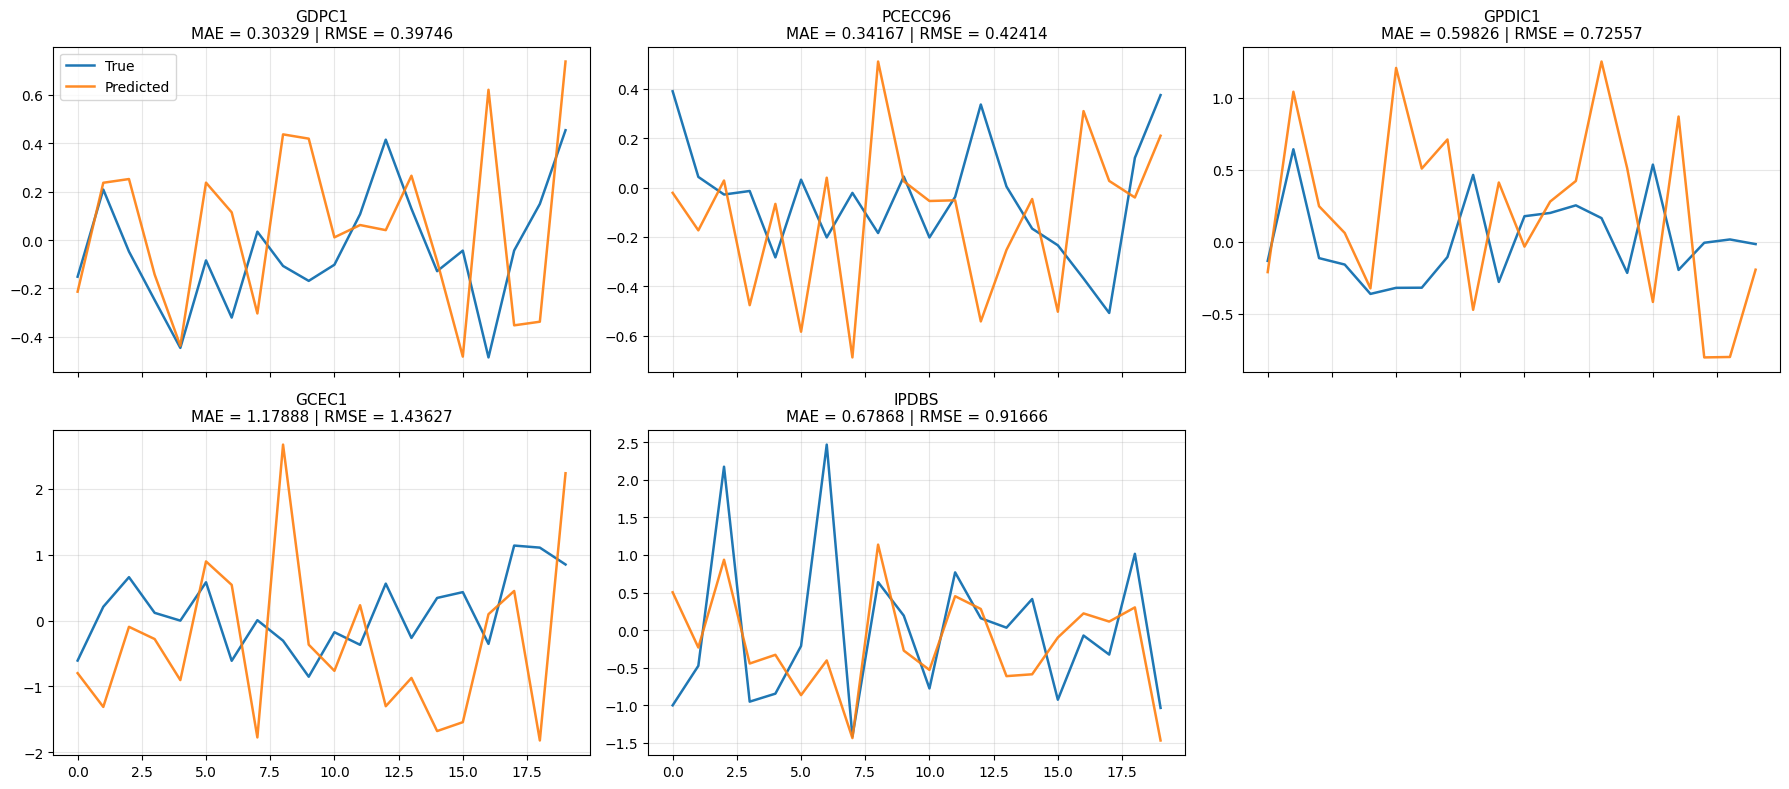


All direct multi-step forecasts and plots saved successfully.


In [5]:
k = 1
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'Powell'  # 'Powell' or 'L-BFGS-B'
inits = [0,0,0,0]
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_MIDAS = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1

    for t in range(T_test):
        print(f'==== Step {t}')
        X_H_train = X_H[:, :(T_train+T_val+t-target_horizon+1)*d1*d2] 
        X_M_train = X_M[:, :(T_train+T_val+t-target_horizon+1)*d2] 
        Y_train = Y[:, target_horizon-1:(T_train+T_val+t)] 
        X_H_test = X_H[:, (T_train+T_val+t-k-target_horizon+1)*d1*d2:(T_train+T_val+t-target_horizon+1)*d1*d2]     
        X_M_test = X_M[:, (T_train+T_val+t-k-target_horizon+1)*d2:(T_train+T_val+t-target_horizon+1)*d2]        
        Y_test = Y[:, T_train + T_val - k + t-target_horizon+1: T_train + T_val + t-target_horizon+1]    
                    
        model, w_high, w_med = three_freq_midas_lagged_regression(Y_train, X_M_train, X_H_train, d1, d2, k, Weight_choice, device, Q=5
                                                                  ,method=method,inits=inits)
        forecast_MIDAS = midas_forecast_low_only(
            model, Y_test, X_M_test, X_H_test, k, d1, d2, w_high, w_med, device)
        forecasts_multi[i, :, t] = forecast_MIDAS
        # print('forecast_test_MIDAS', forecast_test_MIDAS)
# Calculate forecast errors
Y_true = Y[:Q, T_train + T_val:] 
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS_{Weight_choice}_k{k}_horizon{h+1}.png',
        title_prefix=f'MIDAS Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")



Post-COVID19

In [3]:
T = 208
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print('Y shape:', Y.shape)
print('X_M shape:', X_M.shape)
print('X_H shape:', X_H.shape)
print('Y max:', np.max(Y), 'Y min:', np.min(Y), 'Y mean:', np.mean(Y), 'Y std:', np.std(Y))
print('X_M max:', np.max(X_M), 'X_M min:', np.min(X_M), 'X_M mean:', np.mean(X_M), 'X_M std:', np.std(X_M))
print('X_H max:', np.max(X_H), 'X_H min:', np.min(X_H), 'X_H mean:', np.mean(X_H), 'X_H std:', np.std(X_H))

# Y_total = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
# print('Y_total shape:', Y_total.shape)

T 208 T_H: 12480 T_M: 624
T_train: 168 T_val: 20 T_test: 20
Y shape: (9, 208)
X_M shape: (56, 624)
X_H shape: (13, 12480)
Y max: 9.083060657379114 Y min: -8.981419418585231 Y mean: -7.591268544445516e-18 Y std: 1.0
X_M max: 24.694614539572694 X_M min: -24.295703738737302 X_M mean: 3.100897642039128e-18 X_M std: 1.0
X_H max: 30.816445727888585 X_H min: -33.0391984692243 X_H mean: -1.25255930983351e-17 X_H std: 1.0000000000000169


==== Step 0
Y_final_np (187, 5)
X_final_np (187, 78)
params_high tensor([-0.9539, -0.0051], device='cuda:0')
params_med tensor([-1.3551, -0.1617], device='cuda:0')
w_high [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0001 0.0002 0.0006 0.0016 0.0044 0.0121 0.033  0.0887 0.2363 0.623 ]
w_med [0.0155 0.1349 0.8496]
w_high [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0001 0.0002 0.0006 0.0016 0.0044 0.0121 0.033  0.0887 0.2363 0.623 ]
w_med [0.0155 0.1349 0.8496]
X_low_t torch.Size([9, 1])
X_low_freq torch.Size([69, 1])
==== Step 1
Y_final_np (188, 5)
X_final_np (188, 78)
params_high tensor([-0.1335,  0.0314], device='cuda:0')
params_med tensor([0.0000, 0.1406], device='cuda:0')
w_high [0.6515 0.2185 0.078  0.0297 0.012  0.0052 0.0024 0.0012 0.0006 0.0003
 0.0002 0.0001 0.0001 0.0001 0.     0.     0.     0.     0.     0.    ]
w_med [0.5495 0.2721 0.1785]
w_high [0.6515 0.2185 0.078  0.0297 0.012  0.0052 0.0024 0.0012 0.0006 0.0003
 0.0002 0

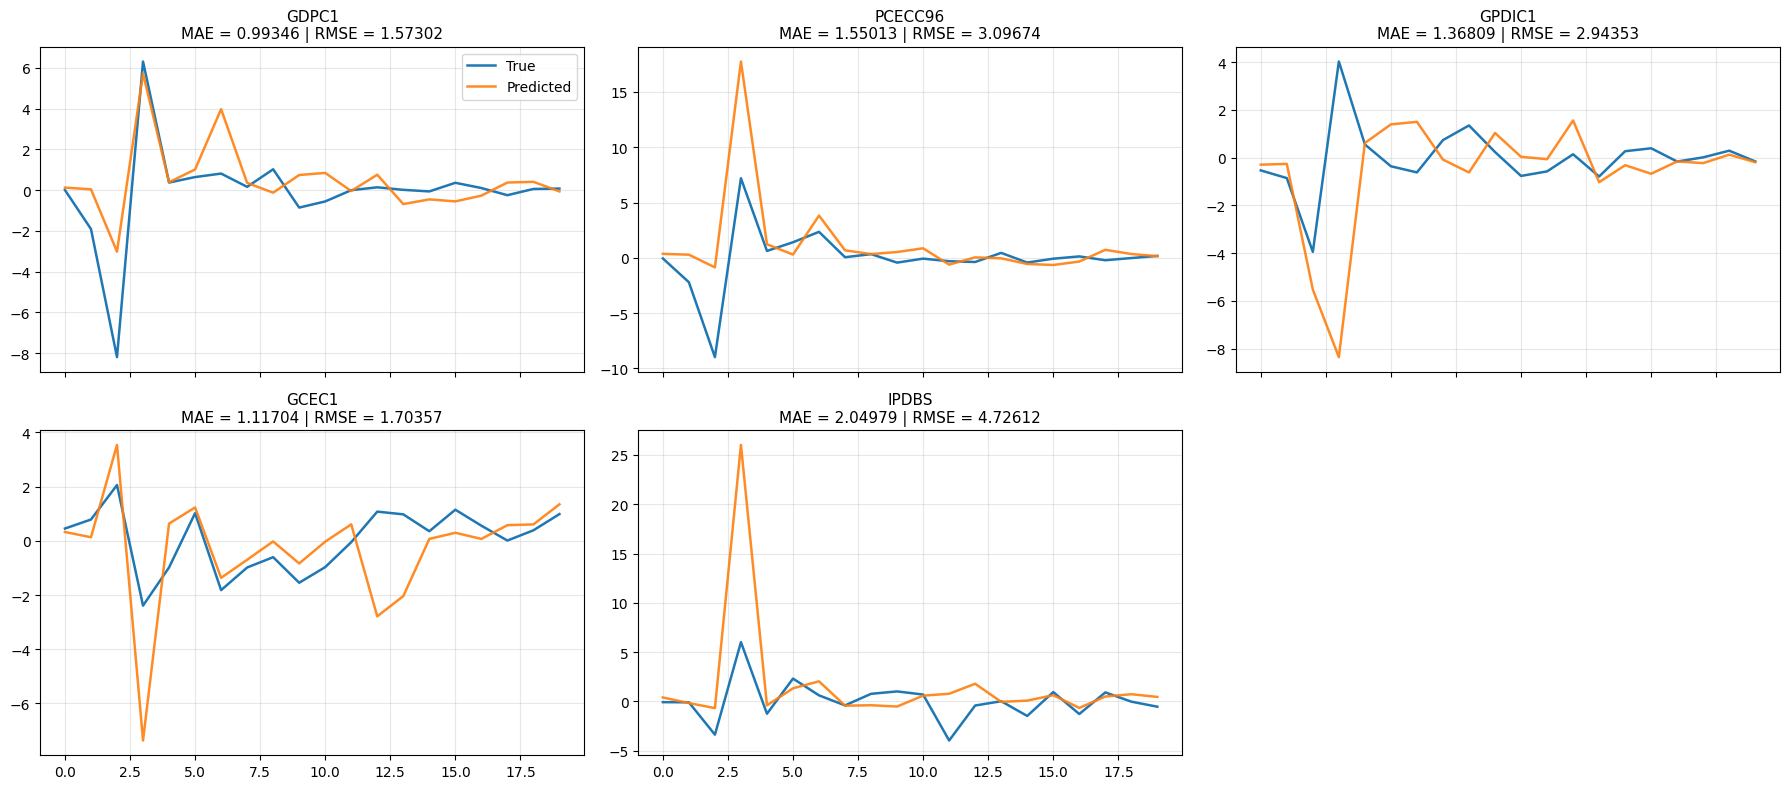


All direct multi-step forecasts and plots saved successfully.


In [9]:
k = 1
Weight_choice = 'Nealmon'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'  # 'Powell' or 'L-BFGS-B'
inits = [0,0,0,0]
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_MIDAS = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1

    for t in range(T_test):
        print(f'==== Step {t}')
        X_H_train = X_H[:, :(T_train+T_val+t-target_horizon+1)*d1*d2] 
        X_M_train = X_M[:, :(T_train+T_val+t-target_horizon+1)*d2] 
        Y_train = Y[:, target_horizon-1:(T_train+T_val+t)] 
        X_H_test = X_H[:, (T_train+T_val+t-k-target_horizon+1)*d1*d2:(T_train+T_val+t-target_horizon+1)*d1*d2]     
        X_M_test = X_M[:, (T_train+T_val+t-k-target_horizon+1)*d2:(T_train+T_val+t-target_horizon+1)*d2]        
        Y_test = Y[:, T_train + T_val - k + t-target_horizon+1: T_train + T_val + t-target_horizon+1]    
                    
        model, w_high, w_med = three_freq_midas_lagged_regression(Y_train, X_M_train, X_H_train, d1, d2, k, Weight_choice, device, Q=5
                                                                  ,method=method,inits=inits)
        print('w_high',w_high)
        print('w_med',w_med)
        forecast_MIDAS = midas_forecast_low_only(
            model, Y_test, X_M_test, X_H_test, k, d1, d2, w_high, w_med, device)
        forecasts_multi[i, :, t] = forecast_MIDAS
        # print('forecast_test_MIDAS', forecast_test_MIDAS)
# Calculate forecast errors
Y_true = Y[:Q, T_train + T_val:] 
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS_{Weight_choice}_k{k}_horizon{h+1}.png',
        title_prefix=f'MIDAS Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")



==== Step 0


==== Step 1
==== Step 2
==== Step 3
==== Step 4
==== Step 5
==== Step 6
==== Step 7
==== Step 8
==== Step 9
==== Step 10
==== Step 11
==== Step 12
==== Step 13
==== Step 14
==== Step 15
==== Step 16
==== Step 17
==== Step 18
==== Step 19

=== Horizon 1 (Direct Forecast t+1) ===
True matrix:
 [[ 0.0094 -0.0574 -0.5375  0.4535 -0.0691]
 [-1.9047 -2.2082 -0.8595  0.7866 -0.0862]
 [-8.1907 -8.9814 -3.9476  2.0583 -3.3639]
 [ 6.3158  7.1969  4.0204 -2.3905  6.0163]
 [ 0.3765  0.6239  0.5493 -0.9811 -1.2441]
 [ 0.6448  1.4071 -0.3649  1.0205  2.32  ]
 [ 0.8169  2.3501 -0.6214 -1.8182  0.6188]
 [ 0.1653  0.0531  0.7308 -0.9843 -0.3972]
 [ 1.0276  0.3341  1.3441 -0.6027  0.7771]
 [-0.8525 -0.4331  0.2323 -1.546   1.02  ]
 [-0.5509 -0.0735 -0.7694 -0.9696  0.7022]
 [ 0.0014 -0.308  -0.5795 -0.0493 -3.956 ]
 [ 0.1425 -0.3764  0.1376  1.0772 -0.4086]
 [ 0.0186  0.4471 -0.7935  0.9776  0.0249]
 [-0.0591 -0.4279  0.2661  0.354  -1.4675]
 [ 0.3645 -0.0796  0.3879  1.1485  0.9544]
 [ 0.1068  0.1276 -

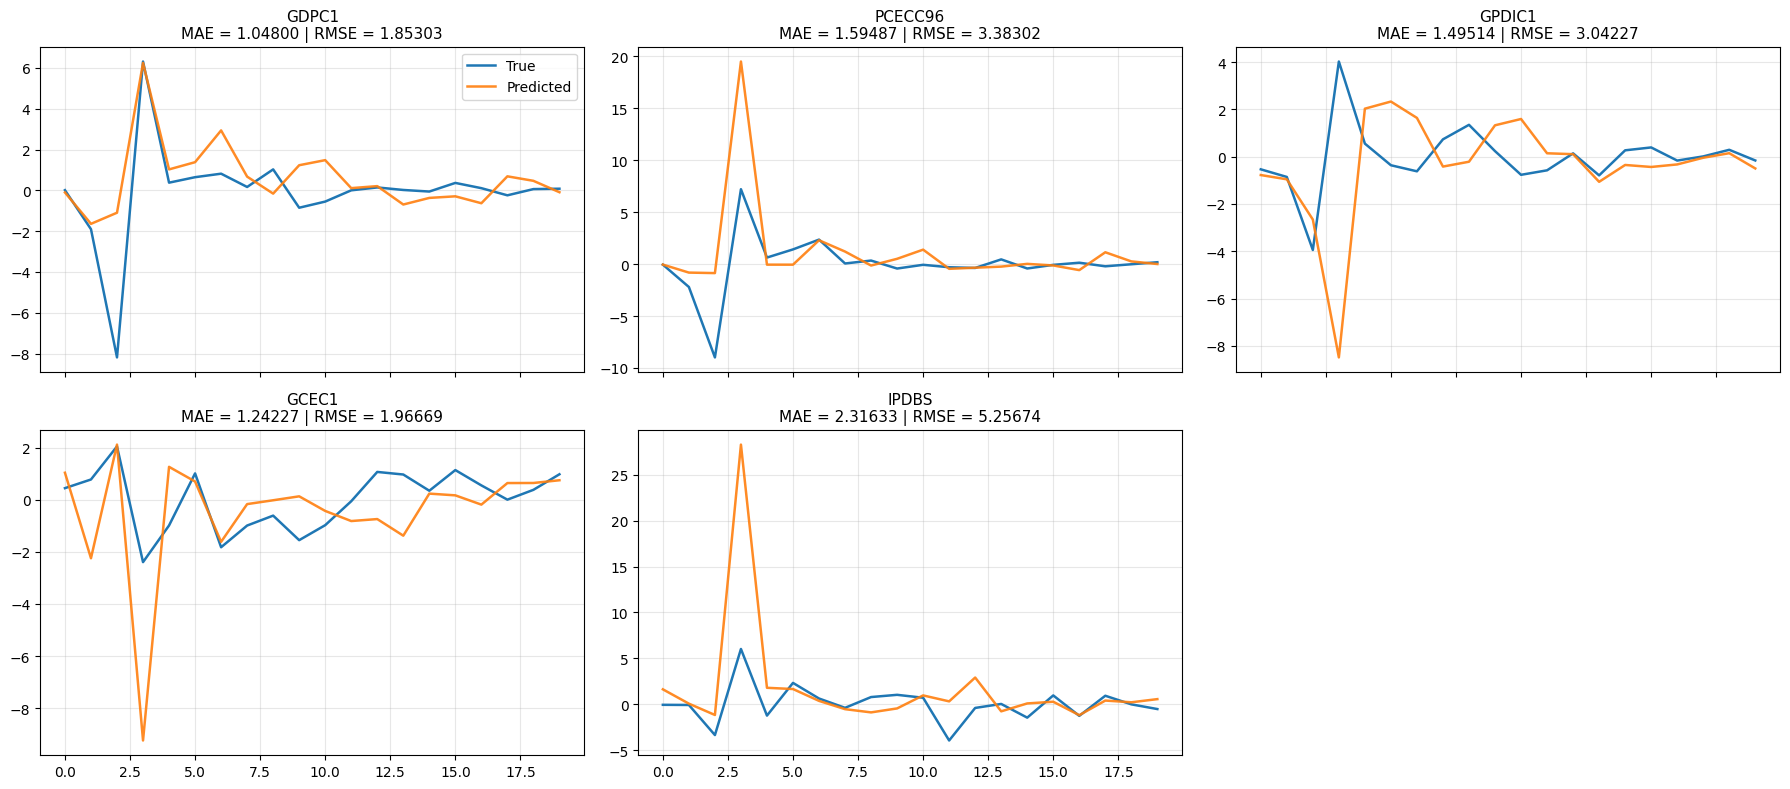


All direct multi-step forecasts and plots saved successfully.


In [4]:
k = 1
Weight_choice = 'Beta'  # 'Nealmon' or 'Beta'
method = 'L-BFGS-B'  # 'Powell' or 'L-BFGS-B'
inits = [1,1,1,1]
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_MIDAS = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1

    for t in range(T_test):
        print(f'==== Step {t}')
        X_H_train = X_H[:, :(T_train+T_val+t-target_horizon+1)*d1*d2] 
        X_M_train = X_M[:, :(T_train+T_val+t-target_horizon+1)*d2] 
        Y_train = Y[:, target_horizon-1:(T_train+T_val+t)] 
        X_H_test = X_H[:, (T_train+T_val+t-k-target_horizon+1)*d1*d2:(T_train+T_val+t-target_horizon+1)*d1*d2]     
        X_M_test = X_M[:, (T_train+T_val+t-k-target_horizon+1)*d2:(T_train+T_val+t-target_horizon+1)*d2]        
        Y_test = Y[:, T_train + T_val - k + t-target_horizon+1: T_train + T_val + t-target_horizon+1]    
                    
        model, w_high, w_med = three_freq_midas_lagged_regression(Y_train, X_M_train, X_H_train, d1, d2, k, Weight_choice, device, Q=5
                                                                  ,method=method,inits=inits)
        forecast_MIDAS = midas_forecast_low_only(
            model, Y_test, X_M_test, X_H_test, k, d1, d2, w_high, w_med, device)
        forecasts_multi[i, :, t] = forecast_MIDAS
        # print('forecast_test_MIDAS', forecast_test_MIDAS)
# Calculate forecast errors
Y_true = Y[:Q, T_train + T_val:] 
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/MIDAS_{Weight_choice}_k{k}_horizon{h+1}.png',
        title_prefix=f'MIDAS Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")

